In [71]:
import numpy as np
import pandas as pd 
from numpy import linalg as la
from scipy.stats import norm
from scipy import optimize
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

import tobit
import tibot
import estimation
import LinearModels as lm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


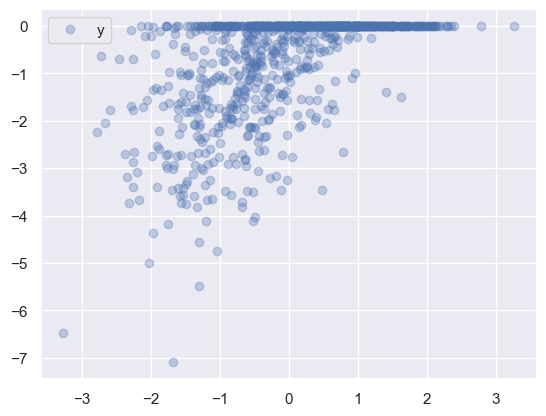

In [72]:
# Load data
data = pd.read_csv('adv micro data.csv')
y = data['y'].values
x = data[['x']].values

fig,ax = plt.subplots();
ax.plot(x, y, 'o', alpha=0.3, label='y');
ax.legend();
plt.show()

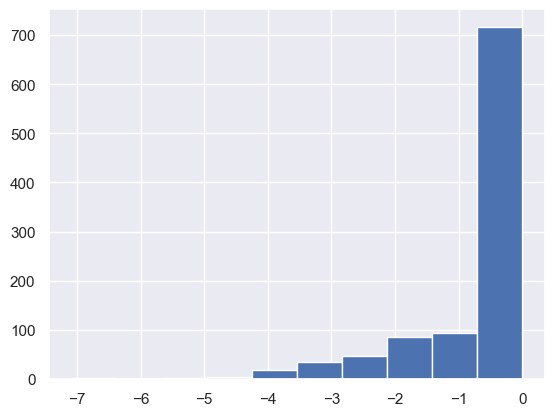

In [76]:
plt.hist(y) ;
#plt.hist(x)

In [77]:
theta = tobit.starting_values(y,x)
ll0 = tobit.loglikelihood(theta, y, x)

In [78]:
res = estimation.estimate(tobit.q, theta, y, x)
result_dict = {'theta_0': theta, 
              'thetahat': res['theta'], 
              't': res['t']}
lab_theta = ['x1', 'sigma']

pd.DataFrame(result_dict, index=lab_theta).round(3)

Optimization terminated successfully.
         Current function value: 0.337212
         Iterations: 6
         Function evaluations: 21
         Gradient evaluations: 7


,theta_0,thetahat,t
x1,0.586,-1.016,-0.0
sigma,1.065,1.365,0.0


In [90]:
# Compute R2
sigma_tob = res.get('theta')[-1]
sig_tob   = res.get('theta')[-1]
b_tob     = res.get('theta')[:-1]
b_se_tob  = res.get('se')[:-1]

xb = x@b_tob
y_hat = xb*norm.cdf(xb/sigma_tob) + sigma_tob*norm.pdf(xb/sigma_tob)
residuals = y_hat - xb
mu = np.mean(residuals)
print('Mean of residuals:', mu)
rho = np.corrcoef(y.flatten(), y_hat.flatten())[0, 1]
R2_tob = rho*rho

tab = pd.DataFrame({'b_tobit': b_tob, 'se': b_se_tob}, index=['x'])
tab = pd.concat([tab,pd.DataFrame({ 'b_tobit': sig_tob, 'se': res['se'][-1]}, index=['sigma'])])
tab = pd.concat([tab,pd.DataFrame({'b_tobit': '', 'se': R2_tob}, index=['R2'])])

tab.round(5)

Mean of residuals: 0.6688491853608395


,b_tobit,se
x,-1.015516,6.316597e+06
sigma,1.364719,8.488674e+06
R2,,3.372700e-01


In [80]:
theta0 = tibot.starting_values(y,x)
ll0 = tibot.loglikelihood(theta0, y, x)

In [89]:
res1 = estimation.estimate(tibot.q, theta0, y, x)
result_dict1 = {'Starting values': theta0, 
              'Estimated values': res1['theta'], 
              't': res1['t']}
lab_theta = ['x', 'sigma']

pd.DataFrame(result_dict1, index=lab_theta).round(3)

Optimization terminated successfully.
         Current function value: 1.167912
         Iterations: 8
         Function evaluations: 27
         Gradient evaluations: 9


,Starting values,Estimated values,t
x,0.586,0.897,20.866
sigma,1.065,1.548,22.997


In [88]:
sigma1_tibot = res1.get('theta')[-1]
sig1_tibot   = res1.get('theta')[-1]
b1_tibot     = res1.get('theta')[:-1]
b1_se_tibot  = res1.get('se')[:-1]

xb1 = x@b1_tibot
y_hat1 = xb1*norm.cdf((xb1)/sigma1_tibot) + sigma1_tibot*norm.pdf((xb1)/sigma1_tibot)
residuals = y_hat1 - xb1
mu = np.mean(residuals)
rho1 = np.corrcoef(y.flatten(), y_hat1.flatten())[0, 1]
R2_tibot = rho1*rho1

tab1 = pd.DataFrame({'b_tibot': b1_tibot, 'se': b1_se_tibot}, index=['x'])
tab1 = pd.concat([tab1,pd.DataFrame({'b_tibot': sig1_tibot, 'se': res1['se'][-1]}, index=['sigma'])])
tab1 = pd.concat([tab1,pd.DataFrame({'b_tibot': mu, 'se': np.std(residuals)}, index=['mu'])])
tab1 = pd.concat([tab1,pd.DataFrame({'b_tibot': '', 'se': R2_tibot}, index=['R2'])])

tab1.round(5)

,b_tibot,se
x,0.897002,0.04299
sigma,1.54835,0.06733
mu,0.725666,0.47650
R2,,0.22679


## Partial effects 


In [87]:
thetahat = res1.get('theta')
b_tob = thetahat[:-1]
sigma_tob = thetahat[-1]

x0 = np.mean(x, axis=0)
x0 = x0*x0  # Square of mean, and not mean of square.

def mills_ratio(z):
    return norm.pdf(z) / norm.cdf(z)

def marg_effect(x, b_tob, sigma_tob, mu):
    xb = x@b_tob
    phi = norm.cdf(xb/sigma_tob)
    
    h = 1e-8
    phi = np.clip(phi, h, 1-h)

    # Implied "censoring" probability
    marg_1 = 1 - norm.cdf((xb + mu)/sigma_tob)

    # dE(y|x,y>0)/dx, see eq.(7)
    lam = mills_ratio(xb/sigma_tob)  # Inverse Mills ratio
    factor = 1 - lam*(xb/sigma_tob + lam)  # the square bracket
    margeff_1 = np.outer(b_tob, factor)  # eq. (y)

    # dE(y|x)/dx, see eq.(8)
    margeff_2 = np.outer(b_tob, phi)

    return marg_1, margeff_1, margeff_2

# Calculate the marginal effect and print out the effect
margeff_1, margeff_2 = marg_effect(x0, b_tob, sigma_tob)
table = [
    ['dE(y|x,y<0)/dx', margeff_1], 
    ['dE(y|x)/dx', margeff_2]
]
print('Marginal effect')
print(tabulate(table))

Marginal effect
--------------  --------
dE(y|x,y<0)/dx  0.326014
dE(y|x)/dx      0.448614
--------------  --------
